In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("megware-amplitude.csv")

In [3]:
df["time"] = pd.to_datetime(df["Time"])
df["power"] = df["Total Power\n(W)"]
df['power [kW]'] = df["power"] / 1e3

In [4]:
core_datetime_start_string = "2023-05-10 19:58:00"
core_datetime_end_string = "2023-05-10 20:01:15"
core_phase_start = pd.to_datetime(core_datetime_start_string)
core_phase_end = pd.to_datetime(core_datetime_end_string)
df["time_offset [s]"] = (df["time"] - core_phase_start).dt.total_seconds()

In [5]:
print(f"core phase duration {core_phase_end - core_phase_start}")

core phase duration 0 days 00:03:15


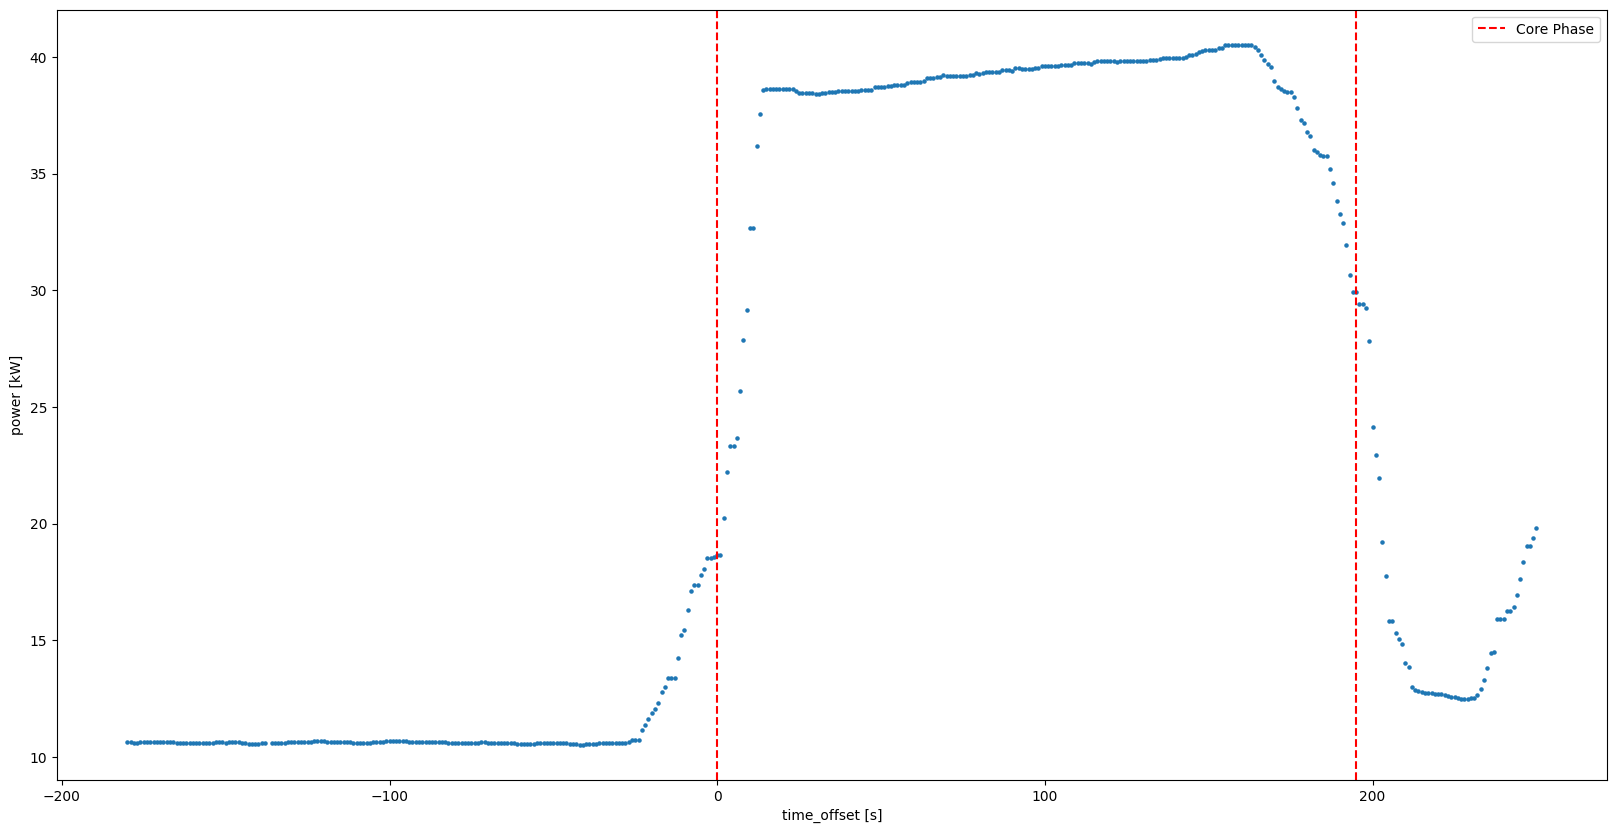

In [6]:
ax = df.plot(x="time_offset [s]", y="power [kW]", kind="scatter", figsize=(20, 10), marker=".")
ax.axvline(0, color='r', linestyle='--', label='Core Phase')
ax.axvline((core_phase_end - core_phase_start).total_seconds(), color='r', linestyle='--')
ax.legend()
ax.set_xlim(-50, 250)

# Assuming 60 second interval (only three datapoints!)

true power: 38.02 kW
Max error 11.90%, mean error 4.40%


(-50.0, 250.0)

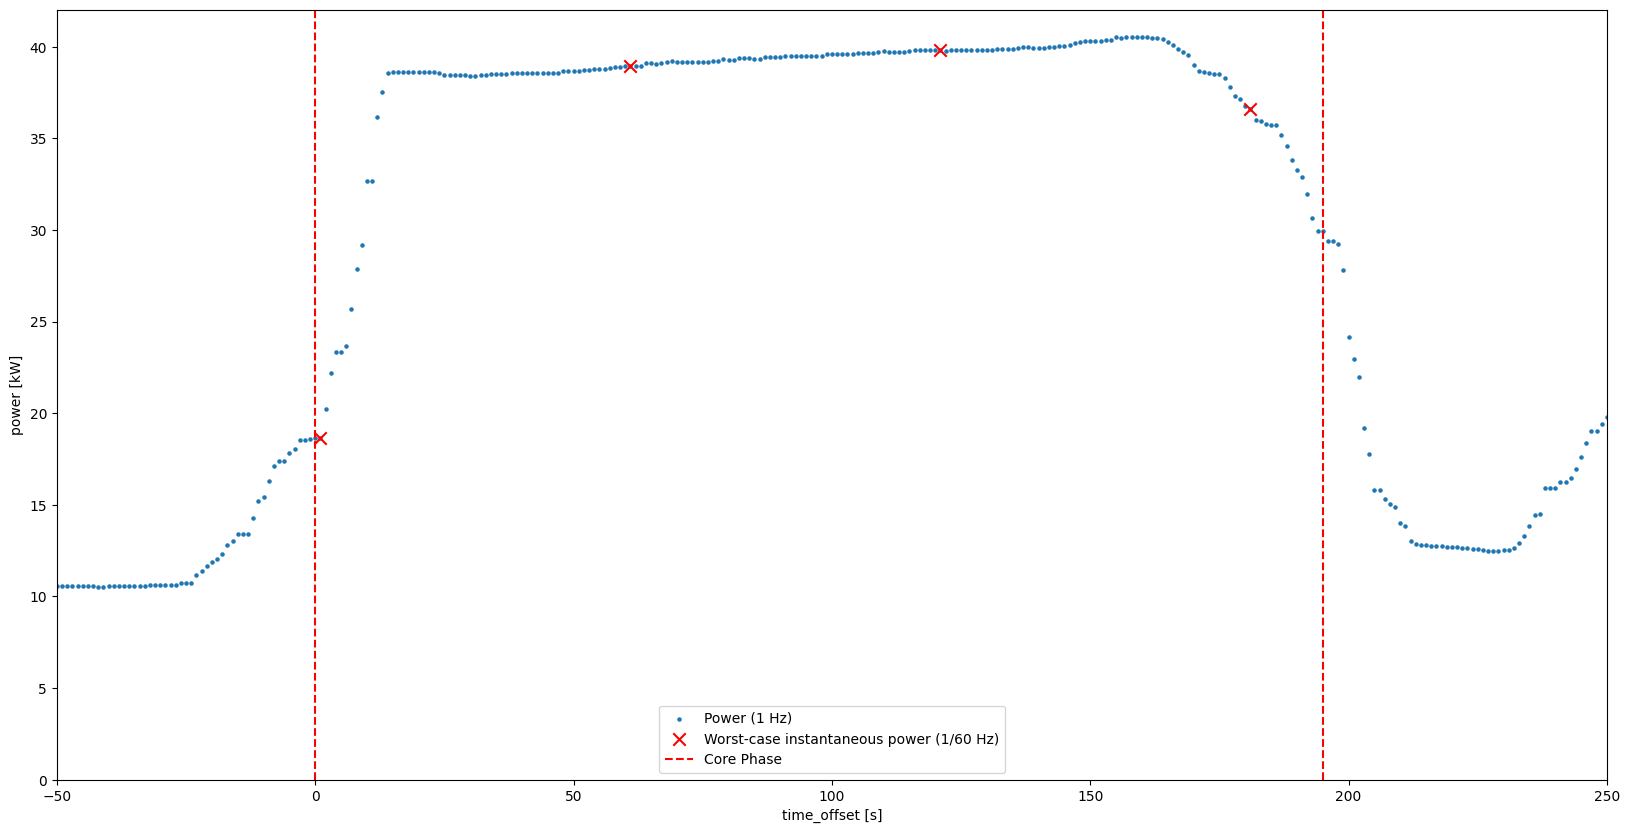

In [7]:
df_core = df[(df["time"] >= core_phase_start) & (df["time"] < core_phase_end)]

true_power = df_core.power.mean()
print(f"true power: {true_power/1000:.2f} kW")
max_error = 0
errors = []
for shift in range(0, 60, 1):
    df_shifted = df_core[df_core["time"].dt.second == shift]
    shifted_power = df_shifted.power.mean()
    error = abs(true_power - shifted_power) / true_power
    errors.append(error)
    if error > max_error:
        max_error = error
        df_worst = df_shifted

print(f"Max error {max_error:.2%}, mean error {sum(errors) / len(errors):.2%}")

ax = df.plot(x="time_offset [s]", y="power [kW]", kind="scatter", figsize=(20, 10), marker=".", label="Power (1 Hz)")
ax.set_ylim(0)
df_worst.plot(x="time_offset [s]", y="power [kW]", kind="scatter", marker="x", s=80, ax=ax, color="red", label="Worst-case instantaneous power (1/60 Hz)")
ax.axvline(0, color='r', linestyle='--', label='Core Phase')
ax.axvline((core_phase_end - core_phase_start).total_seconds(), color='r', linestyle='--')
ax.legend()
ax.set_xlim(-50, 250)

# Shorter intervals for five datapoints

Max error 8.85%, mean error 3.99%


(-50.0, 250.0)

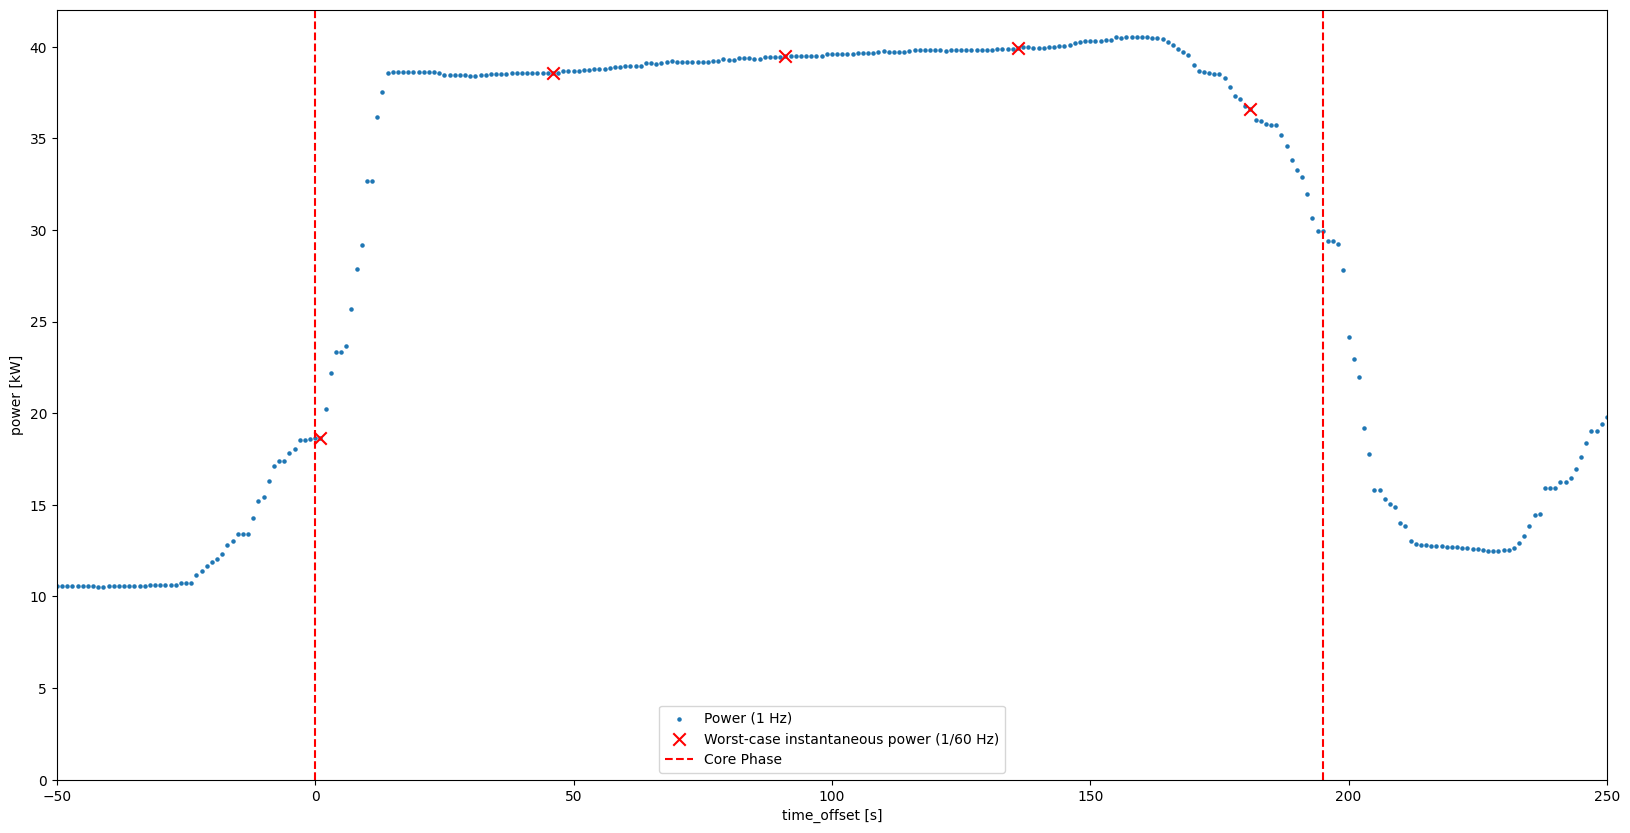

In [15]:
max_error = 0
errors = []
interval = 45
df_core.loc[:, "seconds_in_interval"] = (df_core["time"].astype(int) // 10**9) % interval
for shift in range(0, interval, 1):
    df_shifted = df_core[df_core["seconds_in_interval"] == shift]
    shifted_power = df_shifted.power.mean()
    error = abs(true_power - shifted_power) / true_power
    errors.append(error)
    if error > max_error:
        max_error = error
        df_worst = df_shifted

print(f"Max error {max_error:.2%}, mean error {sum(errors) / len(errors):.2%}")

ax = df.plot(x="time_offset [s]", y="power [kW]", kind="scatter", figsize=(20, 10), marker=".", label="Power (1 Hz)")
ax.set_ylim(0)
df_worst.plot(x="time_offset [s]", y="power [kW]", kind="scatter", marker="x", s=80, ax=ax, color="red", label="Worst-case instantaneous power (1/60 Hz)")
ax.axvline(0, color='r', linestyle='--', label='Core Phase')
ax.axvline((core_phase_end - core_phase_start).total_seconds(), color='r', linestyle='--')
ax.legend()
ax.set_xlim(-50, 250)